In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import glob
import os
from scipy import misc
import math

from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

import gc
import timeit

Using TensorFlow backend.


In [3]:
for phase in glob.glob('phase*'):
    print(phase)

phase3
phase2
phase1


In [5]:
'''
From traffic light msg
uint8 UNKNOWN=4
uint8 GREEN=2
uint8 YELLOW=1
uint8 RED=0
'''

state = {0: 'Red', 1: 'Yellow', 2: 'Green', 3: 'Unknown'}

paths = ['red/*.png', 'yellow/*.png', 'green/*.png', 'other/*.png']

X_all = []
y_all = []
for phase in glob.glob('phase*'):
    for i, path in enumerate(paths):
        for infile in glob.glob(phase+'/'+path):
            img = misc.imread(infile)
    #         img = misc.imresize(img, (48, 48))
    #         img = misc.imresize(img, (32, 32))
            img = misc.imresize(img, (24, 24))
            X_all.append(img)
            label = np.zeros(4)
            label[i] = 1
            y_all.append(label)

X_all = np.array(X_all)
y_all = np.array(y_all)
n_labels = len(y_all[0])
print("{} images loaded with {} classes.".format(len(X_all), n_labels))

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.10, random_state=121)
print("Train Size: {}".format(len(y_train)))
print("Test Size: {}".format(len(y_test)))

7879 images loaded with 4 classes.
Train Size: 7091
Test Size: 788


In [6]:
X_all[0][0][0]

array([169, 202, 233], dtype=uint8)

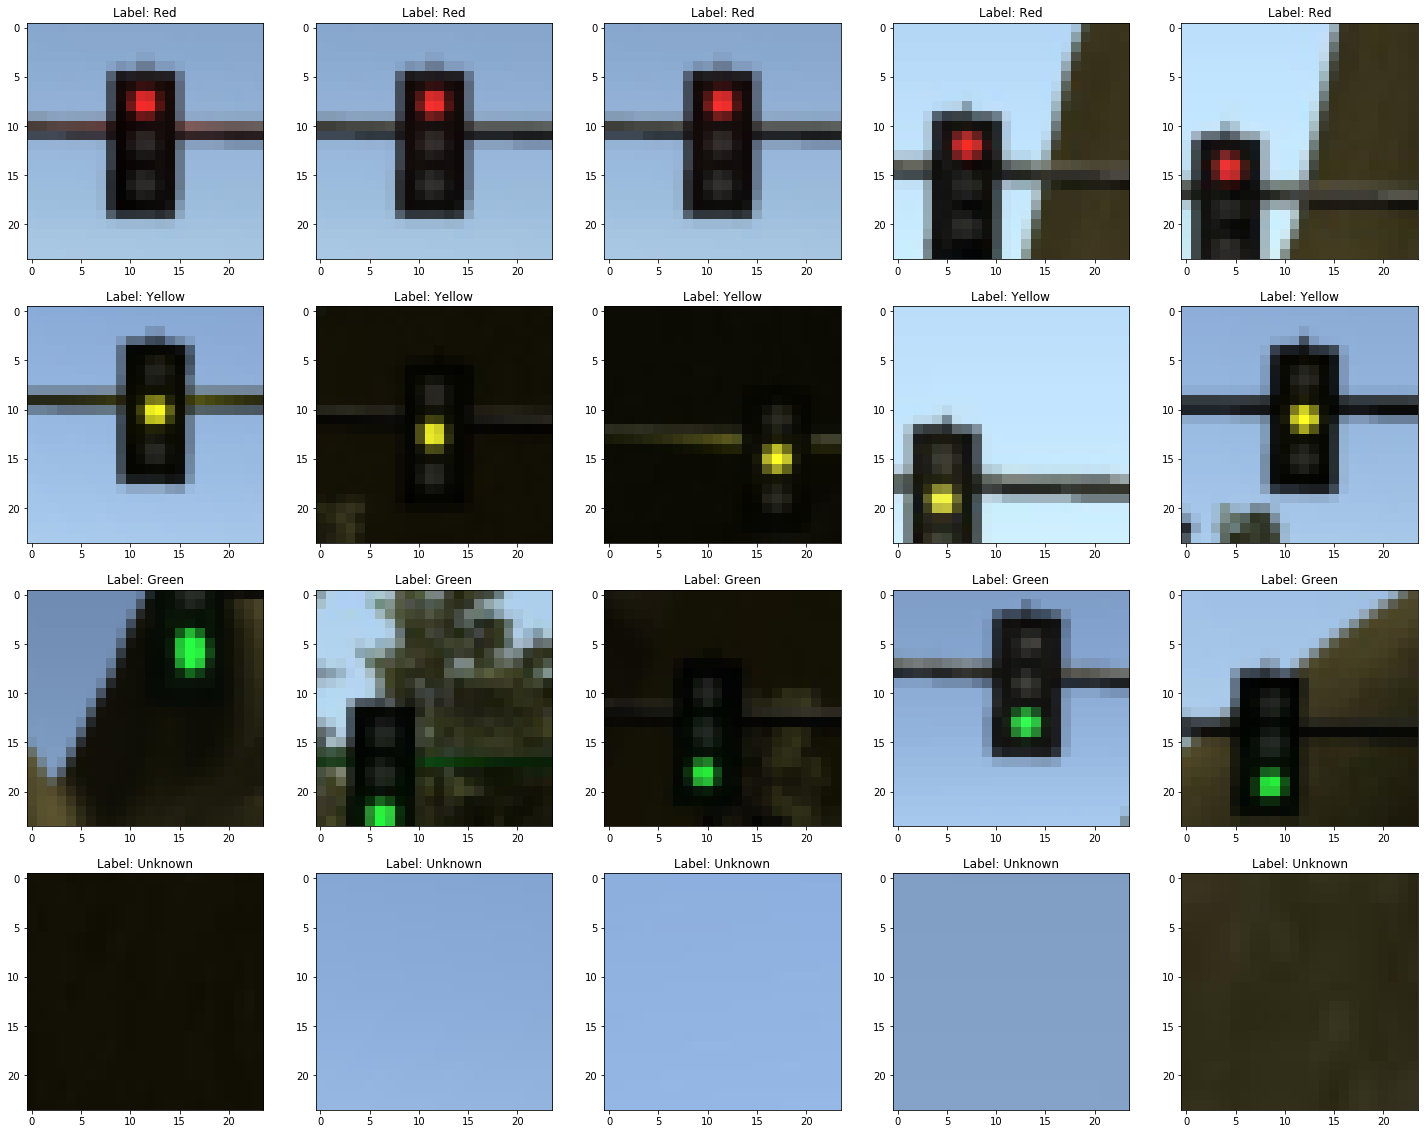

In [7]:
n_examples = 5
plt.subplots(figsize=(5*n_examples, 5*n_labels))
plt_index = 1
for i  in range(len(y_all[0])):
    X_i = X_all[y_all[:,i] == 1]
    for img_index in np.random.randint(0, len(X_i), n_examples):
        plt.subplot(n_labels, n_examples, plt_index)
        plt.imshow(X_i[img_index])
        plt.title("Label: {}".format(state[i]))
        plt_index += 1
plt.show()    

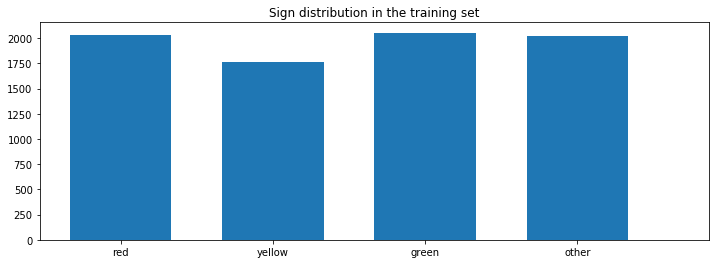

In [8]:
# Look at the distribution of training signs
fig = plt.figure()
fig.set_size_inches(12, 4)
ax = plt.subplot(111)
width = 0.5
ax.hist(np.argmax(y_all, axis=1), bins=n_labels, width=width)
ax.set_xticks([0.25,1,1.75,2.5])
ax.set_xticklabels(['red', 'yellow', 'green', 'other'], rotation=0)
plt.title("Sign distribution in the training set")
plt.show()

In [56]:
batch_size = 5
num_classes = 4
epochs = 20
data_augmentation = True
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'trained_model.h5'

# The data, shuffled and split between train and test sets:
# (x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
# y_train = keras.utils.to_categorical(y_train, num_classes)
# y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()

# Conv layer 1
model.add(Conv2D(12, (3, 3),
                 strides=1,
                 padding='same',
                 input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# Conv layer 2
model.add(Conv2D(6, (3, 3), padding='same'))
model.add(Activation('relu'))

# Pool layer 1
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))
# Conv layer 3
# model.add(Conv2D(8, (3, 3), padding='same'))
model.add(Conv2D(num_classes, (3, 3), padding='same'))
model.add(Activation('relu'))

# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# Conv layer 4
# model.add(Conv2D(8, (3, 3), padding='same'))
# model.add(Conv2D(num_classes, (3, 3), padding='same'))
# model.add(Activation('relu'))

# Pool layer 2
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# FC layers
# model.add(Flatten())
# model.add(Dense(512))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))
# model.add(Dense(num_classes))

# Conv layer 5
# model.add(Conv2D(num_classes, (1, 1), padding='same'))
# model.add(Activation('relu'))

# Global max pool to output
model.add(GlobalMaxPooling2D())
model.add(Activation('softmax'))

# initiate Adam optimizer
opt = keras.optimizers.Adam(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(X_test, y_test),
              shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(X_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(X_train, y_train,
                                     batch_size=batch_size),
                        steps_per_epoch=X_train.shape[0] // batch_size,
                        epochs=epochs,
                        validation_data=(X_test, y_test),
                        workers=4)

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

x_train shape: (7091, 24, 24, 3)
7091 train samples
788 test samples
Using real-time data augmentation.
Epoch 1/20
1418/1418 [==============================] - 8s - loss: 5.5574 - acc: 0.4622 - val_loss: 1.2196 - val_acc: 0.6612
Epoch 2/20
1418/1418 [==============================] - 7s - loss: 1.0295 - acc: 0.7481 - val_loss: 0.5180 - val_acc: 0.8058
Epoch 3/20
1418/1418 [==============================] - 7s - loss: 0.4680 - acc: 0.8929 - val_loss: 0.1809 - val_acc: 0.9645
Epoch 4/20
1418/1418 [==============================] - 7s - loss: 0.2549 - acc: 0.9450 - val_loss: 0.0970 - val_acc: 0.9784
Epoch 5/20
1418/1418 [==============================] - 7s - loss: 0.2101 - acc: 0.9546 - val_loss: 0.0833 - val_acc: 0.9835
Epoch 6/20
1418/1418 [==============================] - 7s - loss: 0.1527 - acc: 0.9664 - val_loss: 0.0668 - val_acc: 0.9822
Epoch 7/20
1418/1418 [==============================] - 7s - loss: 0.1445 - acc: 0.9695 - val_loss: 0.0628 - val_acc: 0.9886
Epoch 8/20
1418/1418 

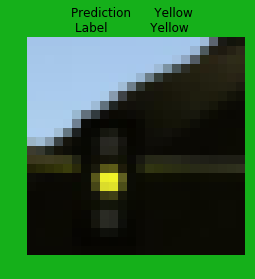

In [57]:
index = np.random.randint(0, len(X_all))
img = X_all[index]
prediction = np.argmax(model.predict(np.array([img])))
label = np.argmax(y_all[index])
if prediction == label:
    plt.figure(facecolor='xkcd:green')
else:
    plt.figure(facecolor='xkcd:red')
plt.imshow(img)
plt.title("{:15} {:8}\n{:15} {:8}".format("Prediction", state[prediction], "Label", state[label]))
plt.axis('off')
plt.show()

In [58]:
gc.collect()

4601

In [8]:
from keras.models import load_model
    
model = load_model('saved_models/trained_model.h5')
np.argmax(model.predict(np.array([img])))

2

In [59]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 24, 24, 12)        336       
_________________________________________________________________
activation_5 (Activation)    (None, 24, 24, 12)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 24, 24, 6)         654       
_________________________________________________________________
activation_6 (Activation)    (None, 24, 24, 6)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 4)         220       
_________________________________________________________________
activation_7 (Activation)    (None, 24, 24, 4)         0         
_________________________________________________________________
global_max_pooling2d_2 (Glob (None, 4)                 0         
__________

In [60]:
from timeit import Timer

def predict(images):
        return model.predict(images)

def get_images(n):
    index_list = np.random.randint(0, len(X_all), n)
    images = []
    labels = []
    for i in index_list:
        images.append(X_all[i])
        labels.append(y_all[i])
    images = np.array(images)
    labels = np.array(labels)
    return images, labels
    

# first argument is the code to be run, the second "setup" argument is only run once,
# and it not included in the execution time.
t = Timer('predict(images)', setup='from __main__ import predict, get_images; images, _ = get_images(100)')
# t = Timer('predict(images, 100)')

n = 200
time = t.timeit(n)
print("{:6.5f}".format(time))
# timeit.timeit('char in text', setup='text = "sample string"; char = "g"')

1.18843


2.00407     4 layer with final conv 3x3 to num classes
2.00286     3 layer with final conv 3x3 to num classes
1.91434     3 layer 16->8->num_classes
1.49570     48x48 img to 32x32 image
1.47931     32x32 img to 24x24 image

99.0% Correct
77


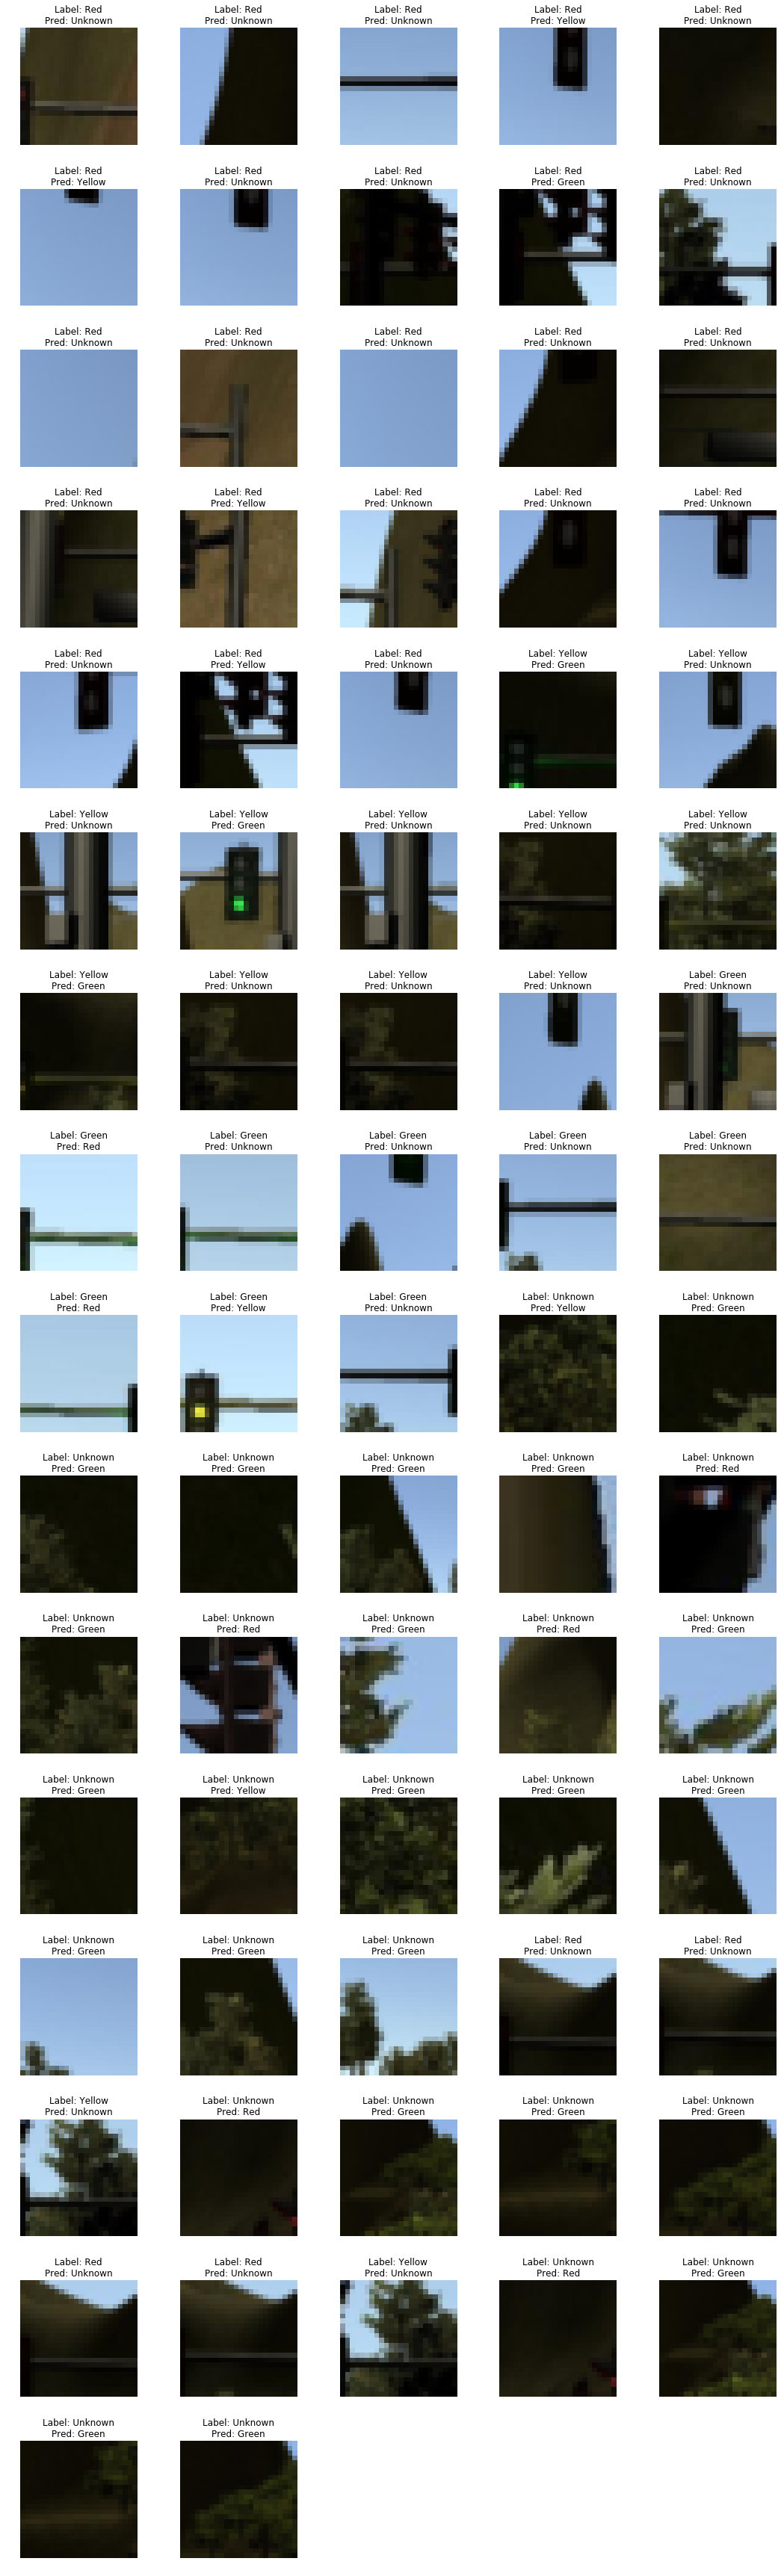

In [61]:
# images, labels = get_images(1000)
images = X_all
labels = y_all
pred = np.argmax(predict(images), axis=1)
correct = np.argmax(labels, axis=1) == pred

labels = np.argmax(labels, axis=1)

print("{:4.3}% Correct".format(100*len(correct[correct==True])/len(correct)))

wrong = np.where(correct==False)
n_wrong = len(wrong[0])
print(n_wrong)

cols = 5
rows = n_wrong//cols+1
plt.subplots(figsize=(3*cols,3*rows))
i = 1
for i, (img, l, p) in enumerate(zip(images[wrong], labels[wrong], pred[wrong])):
    plt.subplot(rows, cols, i+1)
    plt.imshow(img)
    plt.title("Label: {}\nPred: {}".format(state[l], state[p]))
    plt.axis('off')
plt.tight_layout()
plt.show()